In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [2]:
import jax
import jax.numpy as np
import jax.tree_util as jtu

key = jax.random.PRNGKey(1)

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)

import jax_md
import equinox as eqx

import jax_morph as jxm
from jax_morph.visualization import draw_circles_divrate, draw_circles_chem, draw_circles_stress, draw_circles_ctype

import matplotlib.pyplot as plt

# Cell State

In [3]:
#all new cell states must inherit from jxm.BaseCellState
class CellState(jxm.BaseCellState):
    chemical:           jax.Array
    secretion_rate:     jax.Array
    chemical_grad:      jax.Array
    hidden_state:       jax.Array

In [4]:
N_DIM = 2
N_CHEM = 2
N_HIDDEN = 16
N_CTYPES = 2

N = 120
N_ADD = int(N-2)


### Build initial state

disp, shift = jax_md.space.free()

istate = CellState(
    displacement=   disp,
    shift=          shift,
    position=       np.vstack([np.asarray([[-.25, 0],[.25, 0.]]), np.zeros(shape=(N-2,N_DIM))]),
    celltype=       np.vstack([np.eye(N_CTYPES), np.zeros(shape=(N-2,N_CTYPES))]),
    radius=         np.zeros(shape=(N,1)).at[:2].set(.5),
    division=       np.zeros(shape=(N,1)).at[:2].set(1.),
    chemical=       np.zeros(shape=(N,N_CHEM)),
    chemical_grad=  np.zeros(shape=(N,int(N_DIM*N_CHEM))),
    secretion_rate= np.zeros(shape=(N,N_CHEM)).at[:2].set(1.),
    hidden_state=   np.zeros(shape=(N,N_HIDDEN))
)

# Model

**NOTE 1:** Every parameter that is passed as a jax array will be differentiated over and subject to optimization. Every parameter that is passed as a python primitive will be treated as a constant.

**NOTE 2:** There is currently no (easy) way to do the opposite in jax-morph, that is to choose *not* to differentiate w.r.t. a jax array. It is possible in principle but doesn't look like we used this feature that much until now, so its introduction is postponed.

In [5]:
class SecretionMaskByCellType(jxm.SimulationStep):
    ctype_sec_chem:     eqx.field(static=True)

    def return_logprob(self) -> bool:
        return False

    def __init__(self, state, ctype_sec_chem=None):

        if ctype_sec_chem is None:
            self.ctype_sec_chem = np.repeat(np.atleast_2d([1.]*state.chemical.shape[1]), state.celltype.shape[-1], axis=0).tolist()

        else:

            if np.asarray(ctype_sec_chem).shape != (state.celltype.shape[1], state.chemical.shape[1]):
                raise ValueError("ctype_sec_chem must be shape (N_CELLTYPE, N_CHEM)")
            
            self.ctype_sec_chem = ctype_sec_chem
        
        
    @jax.named_scope("jax_morph.SecretionByCellType")
    def __call__(self, state, *, key=None, **kwargs):
            
        sec_mask = state.celltype @ np.atleast_2d(self.ctype_sec_chem)

        secretion_rate = sec_mask*state.secretion_rate

        state = eqx.tree_at(lambda s: s.secretion_rate, state, secretion_rate)

        return state

In [6]:
# key, init_key = jax.random.split(key)


# mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

# model = jxm.Sequential(
#     substeps=[
#         jxm.env.CellDivision(),

#         jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

#         jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),

#         jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=1.),
#         # jxm.env.diffusion.ApproxSteadyStateDiffusion(degradation_rate=.8, diffusion_coeff=.5),

#         jxm.cell.sensing.LocalChemicalGradients(),

#         jxm.cell.GeneNetwork(istate,
#                             input_fields=['chemical', 'chemical_grad', 'division', 'radius'],
#                             output_fields=['secretion_rate', 'division'],
#                             key=init_key,
#                             transform_output={'division': lambda s,x: x*jax.nn.sigmoid(50*(s.radius - .45))},
#                             expr_level_decay=.8,
#                             ),

#         SecretionMaskByCellType(istate, np.eye(N_CTYPES).tolist()),
    # ])


# POSSIBLE REASONS FOR NOT WORKING IN GENERAL:
# - sigmoids in the gene network
# - too small number of params in the gene network
# - gradient problems in the gene network (possibly connected to the sigmoids)

In [7]:
# key, init_key = jax.random.split(key)


# mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

# model = jxm.Sequential(
#     substeps=[
#         jxm.env.CellDivision(),

#         jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

#         jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),

#         jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=1.), #WORKS LESS WELL, BUT STILL WORKS -- ???
#         # jxm.env.diffusion.ApproxSteadyStateDiffusion(degradation_rate=.8, diffusion_coeff=.5),

#         jxm.cell.sensing.LocalChemicalGradients(),

#         jxm.cell.HiddenStateMLP(istate,
#                                 input_fields=['chemical', 'division', 'radius'],
#                                 key=init_key,
#         ),

#         jxm.cell.SecretionMLP(istate,
#                               input_fields=['hidden_state'],
#                               ctype_sec_chem=np.eye(N_CTYPES).tolist(),
#                               key=init_key,
#         ),


#         # SecretionMaskByCellType(istate, np.eye(N_CTYPES).tolist()),

#         jxm.cell.DivisionMLP(istate,
#                              input_fields=['hidden_state'],
#                              key=init_key,
#                              w_init=jax.nn.initializers.glorot_normal(),
#         ),

        
#     ])

In [58]:
key, init_key = jax.random.split(key)


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

model = jxm.Sequential(
    substeps=[
        jxm.env.CellDivision(),

        jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),

        jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=1.),

        jxm.cell.sensing.LocalChemicalGradients(),


        jxm.cell.decisions.mlp.CellStateMLP(istate,
                                            input_fields=['chemical', 'division', 'radius'],
                                            output_fields=['hidden_state'],
                                            memory=.8,
                                            key=init_key,
        ),


        jxm.cell.decisions.mlp.CellStateMLP(istate,
                                            input_fields=['hidden_state'],
                                            output_fields=['secretion_rate'],
                                            transform_output={'secretion_rate': lambda s,x: jax.nn.sigmoid(x/10.)},
                                            key=init_key,
        ),


        SecretionMaskByCellType(istate, np.eye(N_CTYPES).tolist()),

        jxm.cell.decisions.mlp.CellStateMLP(istate,
                                            input_fields=['hidden_state'],
                                            output_fields=['division'],
                                            transform_output={'division': lambda s,x: jax.nn.softplus(x)},
                                            key=init_key,
        ),

        
    ])

# REINFORCE Loss

In [8]:
from functools import partial

In [9]:
@eqx.filter_jit
def reinforce_loss(model, istate, *, cost_fn, key, n_steps=1, BATCH_SIZE=1, GAMMA=.9, LAMBDA=.001):

    subkeys = jax.random.split(key, BATCH_SIZE)
    subkeys = np.asarray(subkeys)

    vsim = jax.vmap(partial(jxm.simulate, history=True), (None, None, 0, None))
    trajectory, logp = vsim(model, istate, subkeys, n_steps)


    istate = jtu.tree_map(lambda x: np.repeat(x[None,None,:,:],BATCH_SIZE,0), istate)

    trajectory = jtu.tree_map(lambda *v: np.concatenate(v,1), *[istate, trajectory])


    cost = jax.vmap(cost_fn)(trajectory)


    #discounted costs
    def _returns(rewards):
        Gs=[]
        G=0
        for r in rewards[::-1]:
            G = r+G*GAMMA
            Gs.append(G)

        return np.array(Gs)[::-1]
    
    
    cost = jax.vmap(_returns)(cost)

    cost = (cost-cost.mean(-1, keepdims=True))/(cost.std(-1, keepdims=True)+1e-8)


    #no - sign because we assume a cost instead of a reward
    loss = np.sum(jax.lax.stop_gradient(cost)*logp)


    #L1 penalty on weights
    reg = jax.tree_map(lambda x: np.abs(x).sum(), eqx.filter(model, eqx.is_array))
    reg = jax.tree_util.tree_reduce(lambda x,y: x+y, reg)

    return loss + LAMBDA*reg

## Cost Functions

In [10]:
def ctype_imbalance(trajectory):

    cost = trajectory.celltype.sum(-2) @ np.asarray([1.,-1.])

    cost = np.abs(cost)

    cost = np.diff(cost)

    return cost


def ctype_entropy(trajectory):

    p = trajectory.celltype.sum(-2) / trajectory.celltype.sum(-2).sum(-1, keepdims=True)

    #no minus sign since higher entropy is better
    cost = (p*np.log(p+1e-8)).sum(-1) 

    cost = np.diff(cost)

    return cost

# Training

In [11]:
import optax
from tqdm import trange
from functools import partial

In [59]:
EPOCHS = 100
BATCH_SIZE = 16


COST_FN = ctype_imbalance
LAMBDA=0.


opt_model = model


optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

key, subkey = jax.random.split(key)

rl, g = eqx.filter_jit(eqx.filter_value_and_grad(reinforce_loss))(opt_model, istate, cost_fn=COST_FN, key=subkey, n_steps=N_ADD, BATCH_SIZE=BATCH_SIZE, LAMBDA=LAMBDA)

l = COST_FN(jxm.simulate(opt_model, istate, subkey, N_ADD, history=True)[0]).sum()

models = [opt_model]
rlosses = [float(rl)]
losses = [float(l)]

pbar = trange(EPOCHS)
for e in pbar:

    try:
        # g = jax.tree_map(lambda x: x/(np.linalg.norm(x)+1e-10), g)

        updates, opt_state = optimizer.update(g, opt_state, opt_model)
        opt_model = eqx.apply_updates(opt_model, updates)

        key, subkey = jax.random.split(key)

        rl, g = eqx.filter_jit(eqx.filter_value_and_grad(reinforce_loss))(opt_model, istate, cost_fn=COST_FN, key=subkey, n_steps=N_ADD, BATCH_SIZE=BATCH_SIZE, LAMBDA=LAMBDA)

        l = COST_FN(jxm.simulate(opt_model, istate, subkey, N_ADD, history=True)[0]).sum()

        models.append(opt_model)
        rlosses.append(float(rl))
        losses.append(float(l))
        
        pbar.set_description(f'Loss: {l:.3f}')

    except FloatingPointError:
        print('NaN or Overflow')
        break

    except KeyboardInterrupt:
        print('Interrupted')
        break

Loss: -1.000: 100%|███████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


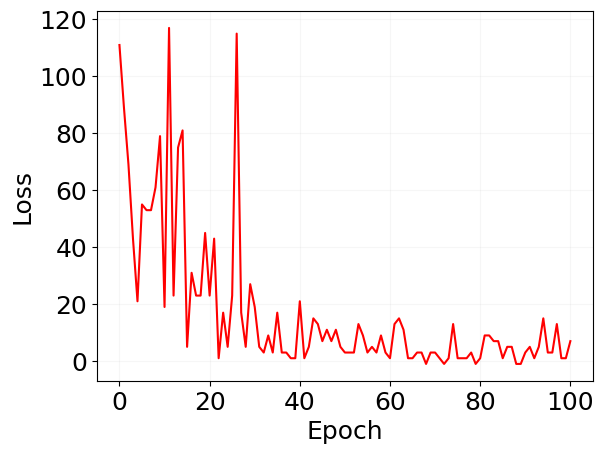

In [ ]:
plt.plot(losses, 'r')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(alpha=.1);

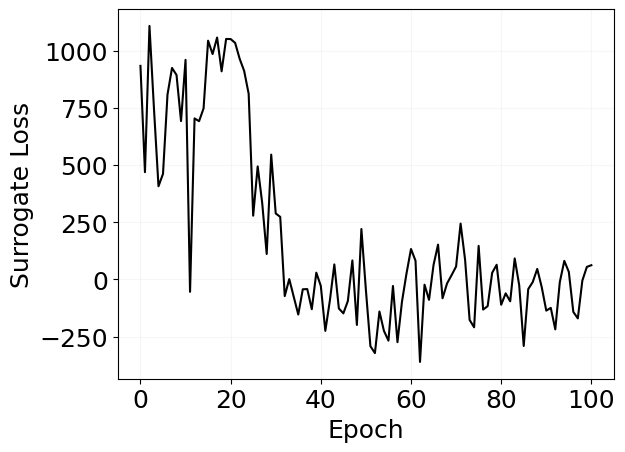

In [60]:
plt.plot(rlosses, 'k')

plt.xlabel('Epoch')
plt.ylabel('Surrogate Loss')

plt.grid(alpha=.1);

In [61]:
def _final_cost_distribution(model, istate, subkeys, n_sim_steps):

    vsim = jax.vmap(jxm.simulate, (None, None, 0, None))

    fstate, _ = vsim(model, istate, subkeys, n_sim_steps)

    cost = fstate.celltype.sum(-2) @ np.asarray([1.,-1.])

    cost = np.abs(cost)

    return cost.tolist()

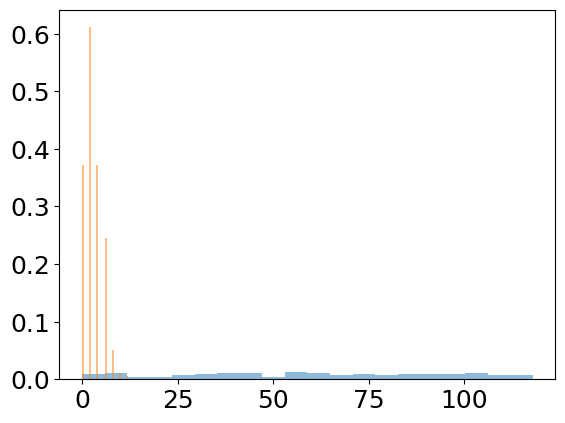

In [62]:
subkeys = np.asarray(jax.random.split(key, 300))

mcost = _final_cost_distribution(model, istate, subkeys, N_ADD)
ocost = _final_cost_distribution(opt_model, istate, subkeys, N_ADD)

plt.hist(mcost, bins=20, alpha=.5, density=True)
plt.hist(ocost, bins=20, alpha=.5, density=True);

## Initial Random Parameters

In [63]:
key, subkey = jax.random.split(key)
ss, _ = jxm.simulate(model, istate, subkey, N_ADD)

print(ss.celltype.sum(0) @ np.asarray([1.,-1.]))

48.0


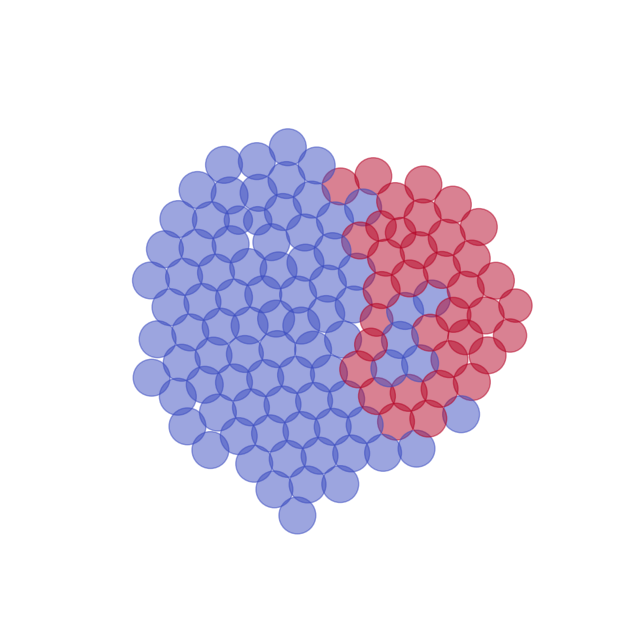

In [64]:
draw_circles_ctype(ss);

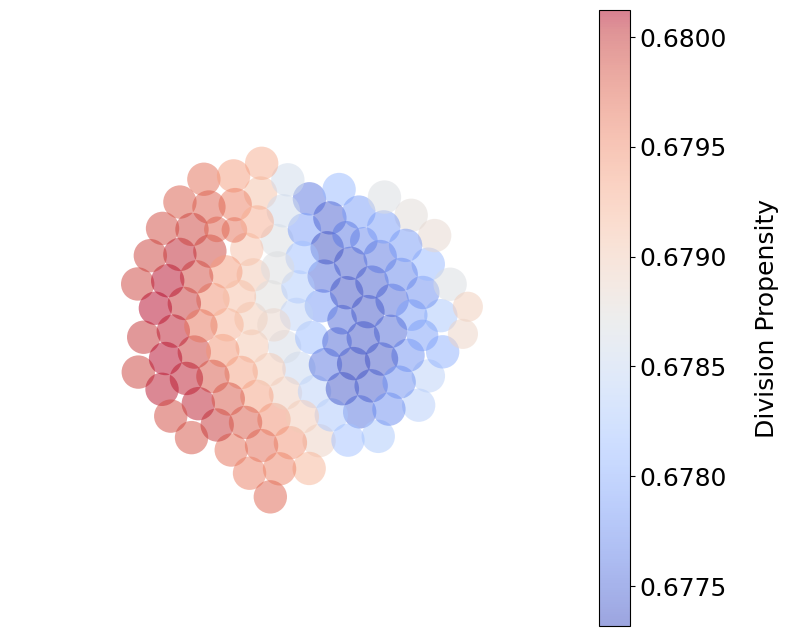

In [65]:
draw_circles_divrate(ss);

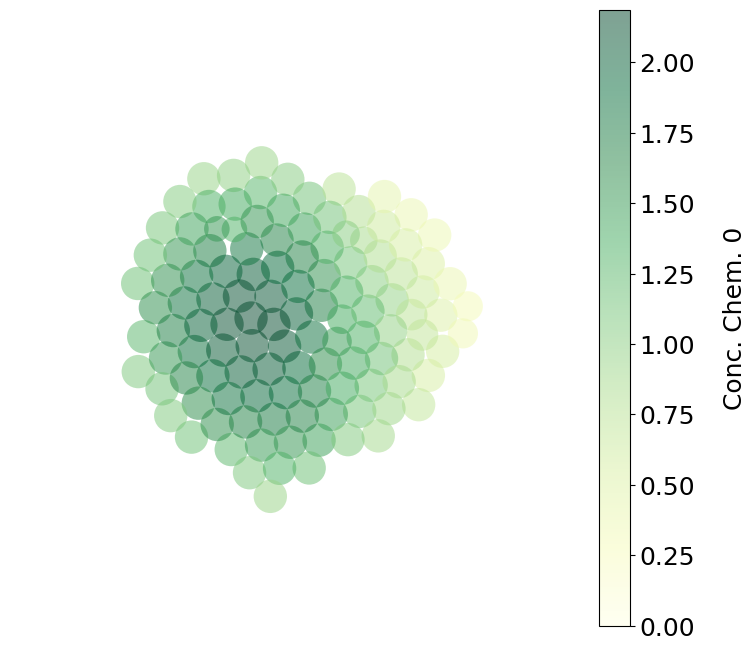

In [66]:
draw_circles_chem(ss, 0);

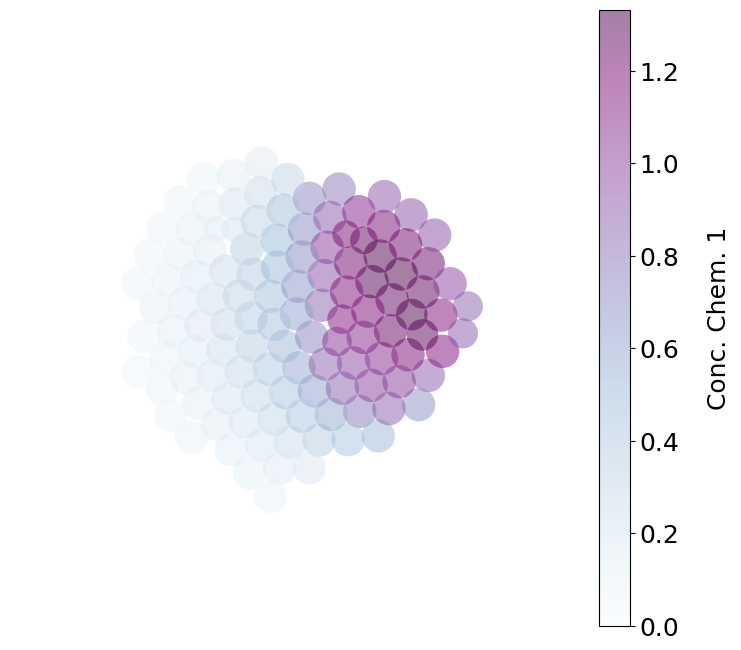

In [67]:
draw_circles_chem(ss, 1);

## Optimized Parameters

In [84]:
key, subkey = jax.random.split(key)
s, _ = jxm.simulate(opt_model, istate, subkey, N_ADD)

print(s.celltype.sum(0) @ np.asarray([1.,-1.]))

-10.0


In [86]:
np.sum(s.celltype.sum(-1)>0)

Array(620, dtype=int64)

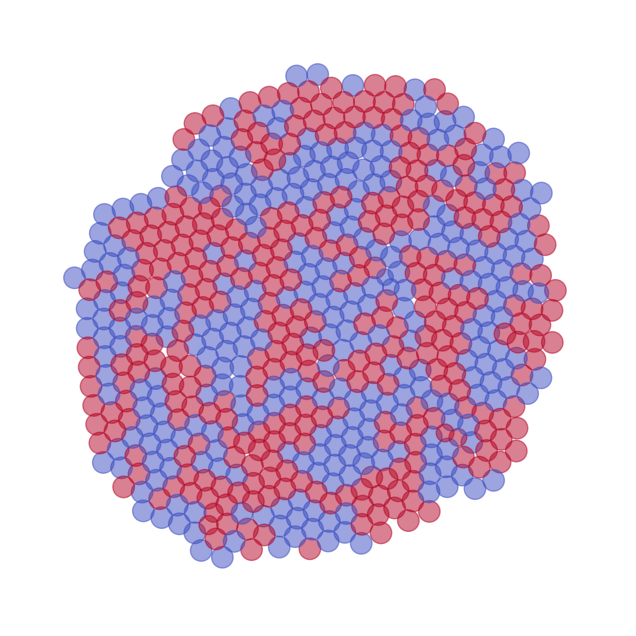

In [85]:
draw_circles_ctype(s);

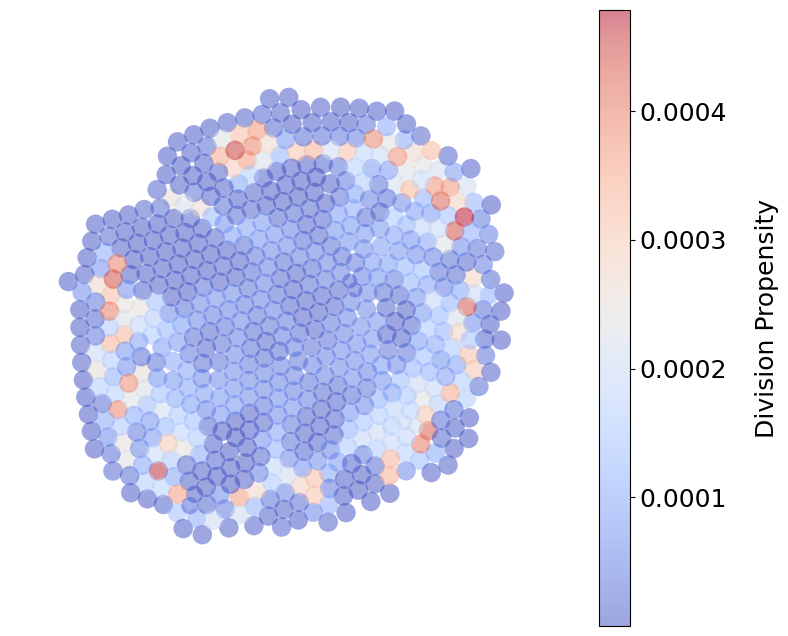

In [87]:
draw_circles_divrate(s);

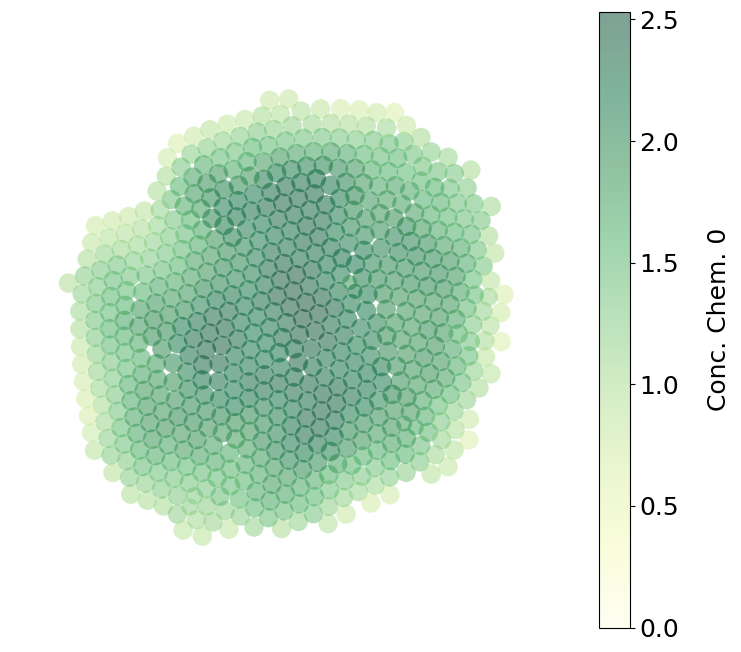

In [88]:
draw_circles_chem(s, 0);

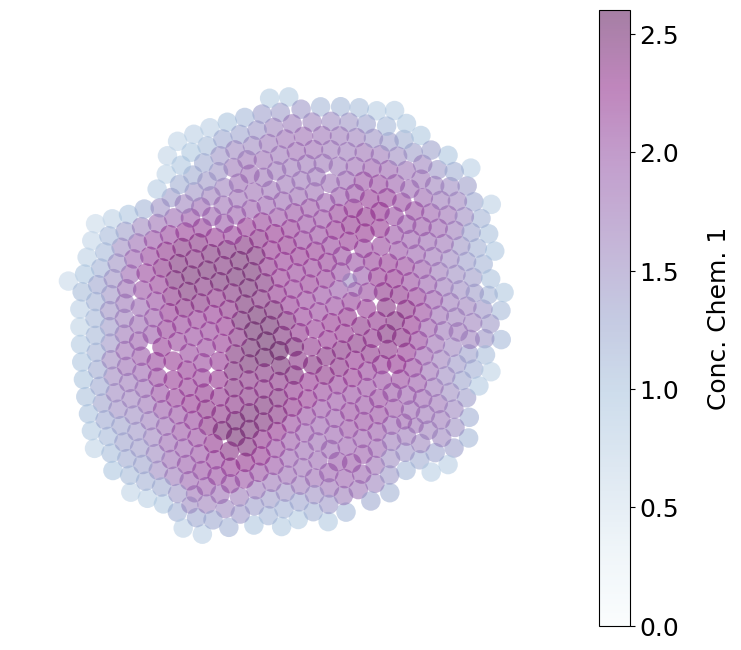

In [89]:
draw_circles_chem(s, 1);